In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=4e65eea1fb6467cafceec92c9d37c97139549af0c28175fccdba81351072f179
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Dosyayı kaggleda buluyoruz, okuma yapmak için.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/california-housing-prices/housing.csv


Spark Session kullanarak işlemimize başlıyoruz.

In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# SparkSession başlatıyoruz.
spark = SparkSession.builder.appName("HousingPricePrediction").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/31 07:54:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


CSV dosyasını okuyarak dataframe olarak atıyoruz.

In [4]:
# Veri setini spark kullanarak okuyoruz.
data_path = os.path.join(dirname, filename)
df = spark.read.csv(data_path, header=True, inferSchema=True)


In [5]:
# Veri setinin ilk birkaç satırını gösteriyoruz
df.show(3)
df.printSchema()


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 3 rows

root
 |--

Columnları kontrol edip, column tiplerine göre feature işlemlerimizi uygulayacağız.

In [6]:
#Columnlara bakıyoruz
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,longitude,double
1,latitude,double
2,housing_median_age,double
3,total_rooms,double
4,total_bedrooms,double
5,population,double
6,households,double
7,median_income,double
8,median_house_value,double
9,ocean_proximity,string


İlk önce columnlarda herhangi bir eksik değer var mı diye kontrol edelim. (None ve NaN cinsinden)

In [7]:
#Check any missing value
for column in df.columns:
    print(column, df.filter(col(column).cast("float").isin([None,np.nan])).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Görüldüğü üzere datasette herhangi bir eksik değer yok. Imputation işlemini direkt yapabiliriz.

In [8]:
#Data imputation işlemini gerçekleştiriyoruz.
df.na.drop()

DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, median_house_value: double, ocean_proximity: string]

Ocean Proximity içerisinde string değerleri olduğu için kontrol ediyoruz.

In [9]:
df.select('ocean_proximity').distinct().show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



Bu string değerlerini label encoder ile kodlayarak, modelimizde kullanabilecek hale getiriyoruz.

In [10]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index") 
df = indexer.fit(df).transform(df)
df = df.drop('ocean_proximity')
df.select('ocean_proximity_index').show(3)

+---------------------+
|ocean_proximity_index|
+---------------------+
|                  3.0|
|                  3.0|
|                  3.0|
+---------------------+
only showing top 3 rows



NULL değerlerin kontrolünü yapaıyoruz, ona göre bu değerleri çıkartacağız.

In [11]:
from pyspark.sql.functions import col

# Tüm sütunlar için null değerlerin sayısını kontrol et
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    print(f"{column} sütunundaki NULL değerlerin sayısı: {null_count}")


longitude sütunundaki NULL değerlerin sayısı: 0
latitude sütunundaki NULL değerlerin sayısı: 0
housing_median_age sütunundaki NULL değerlerin sayısı: 0
total_rooms sütunundaki NULL değerlerin sayısı: 0
total_bedrooms sütunundaki NULL değerlerin sayısı: 207
population sütunundaki NULL değerlerin sayısı: 0
households sütunundaki NULL değerlerin sayısı: 0
median_income sütunundaki NULL değerlerin sayısı: 0
median_house_value sütunundaki NULL değerlerin sayısı: 0
ocean_proximity_index sütunundaki NULL değerlerin sayısı: 0


Görüldüğü üzere total_bedrooms kısmında NULL değerler var, bu değerleri ortalamayla dolduralım.

In [12]:
mean = df.select(F.mean('total_bedrooms')).collect()[0][0]
df = df.na.fill({'total_bedrooms': mean})

Vector Assembler kullanalım ve correlation matrix çizidrelim.

Korelasyon matrisinden çıkarım yapıp tutabileceğimiz featureları göreceğiz.

24/03/31 07:54:53 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


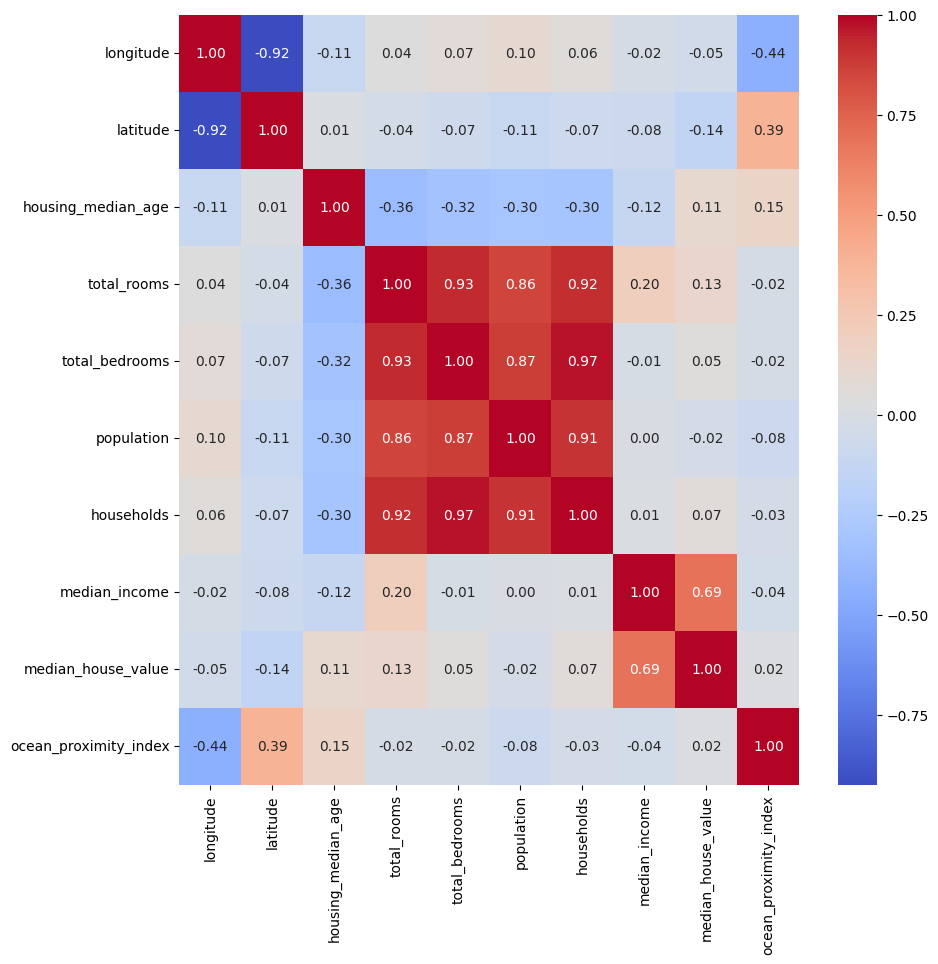

In [13]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
import matplotlib.pyplot as plt

# convert to vector column first
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df_vector = assembler.transform(df).select("features")

# get correlation matrix
matrix = Correlation.corr(df_vector, 'features')
corrmatrix = matrix.collect()[0][0].toArray()

#Converst to pandas dataframe
df_corr = pd.DataFrame(corrmatrix, columns = df.columns, index = df.columns)

# Korelasyon matrisini görselleştirme
plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Burada görüşdüğü üzere sadece housing_median_age, total_rooms, median_income ve median_house_value birbirleriyle correlated şekilde gözüküyor.

In [14]:
#Drop non-correlated columns
df_model = df.select(['housing_median_age','total_rooms', 'median_income','median_house_value'])
df_model.show(3)

+------------------+-----------+-------------+------------------+
|housing_median_age|total_rooms|median_income|median_house_value|
+------------------+-----------+-------------+------------------+
|              41.0|      880.0|       8.3252|          452600.0|
|              21.0|     7099.0|       8.3014|          358500.0|
|              52.0|     1467.0|       7.2574|          352100.0|
+------------------+-----------+-------------+------------------+
only showing top 3 rows



Vector assembler ile tüm featurelarımızı birleştirip kullanmaya başlıyoruz.

In [15]:
#Assembling features
feature_assembly = VectorAssembler(inputCols = ['housing_median_age','total_rooms', 'median_income'], outputCol = 'features')
output = feature_assembly.transform(df_model)
output.show(3)

+------------------+-----------+-------------+------------------+--------------------+
|housing_median_age|total_rooms|median_income|median_house_value|            features|
+------------------+-----------+-------------+------------------+--------------------+
|              41.0|      880.0|       8.3252|          452600.0| [41.0,880.0,8.3252]|
|              21.0|     7099.0|       8.3014|          358500.0|[21.0,7099.0,8.3014]|
|              52.0|     1467.0|       7.2574|          352100.0|[52.0,1467.0,7.2574]|
+------------------+-----------+-------------+------------------+--------------------+
only showing top 3 rows



Birleştirilmiş featureları standart scaler ile scale ediyoruz. Doğruluk oranını arttırmamızda işe yarıyor.

In [16]:
#Normalizing the features
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output)

# Normalize each feature to have unit standard deviation.
scaledOutput = scalerModel.transform(output)
scaledOutput.show(3)

+------------------+-----------+-------------+------------------+--------------------+--------------------+
|housing_median_age|total_rooms|median_income|median_house_value|            features|      scaledFeatures|
+------------------+-----------+-------------+------------------+--------------------+--------------------+
|              41.0|      880.0|       8.3252|          452600.0| [41.0,880.0,8.3252]|[3.25770230160830...|
|              21.0|     7099.0|       8.3014|          358500.0|[21.0,7099.0,8.3014]|[1.66857922765303...|
|              52.0|     1467.0|       7.2574|          352100.0|[52.0,1467.0,7.2574]|[4.13171999228370...|
+------------------+-----------+-------------+------------------+--------------------+--------------------+
only showing top 3 rows



In [17]:
#Selecting input and output column from output
df_model_final = scaledOutput.select(['median_house_value', 'scaledFeatures'])
df_model_final.show(3)

+------------------+--------------------+
|median_house_value|      scaledFeatures|
+------------------+--------------------+
|          452600.0|[3.25770230160830...|
|          358500.0|[1.66857922765303...|
|          352100.0|[4.13171999228370...|
+------------------+--------------------+
only showing top 3 rows



Tüm feature işlemlerinden sonra modelimizi linear regression kullanarak yaratıyoruz.

In [18]:
from pyspark.ml.regression import LinearRegression 

#test train split
df_train, df_test = df_model_final.randomSplit([0.8, 0.2])
regressor = LinearRegression(featuresCol = 'scaledFeatures', labelCol = 'median_house_value')
regressor = regressor.fit(df_train)

24/03/31 07:54:56 WARN Instrumentation: [8c0f3bea] regParam is zero, which might cause numerical instability and overfitting.
24/03/31 07:54:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Train ve test için MSE ve R2 değerlerini kontrol ediyoruz.

In [19]:
#MSE for the train data

pred_results = regressor.evaluate(df_train)
print("The MSE for the model is: %2f"% pred_results.meanAbsoluteError)
print("The r2 for the model is: %2f"% pred_results.r2)


The MSE for the model is: 60086.665614
The r2 for the model is: 0.514362


In [20]:
#Checking train performance
pred_results = regressor.evaluate(df_test)
print("The MSE for the model is: %2f"% pred_results.meanAbsoluteError)
print("The r2 for the model is: %2f"% pred_results.r2)

The MSE for the model is: 59854.377629
The r2 for the model is: 0.510839


En son çıktımız bu şekilde oluyor.


-Ahmet Barış Emre Durak